In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment
from scipy.stats import shapiro
from sklearn.preprocessing import StandardScaler

In [2]:
def determine_optimal_clusters(data, max_k=10):
    distortions = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        kmeans.fit(data)
        distortions.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    return k_range, distortions, silhouette_scores

def preprocess_df(df):
    df['numeric_sort'] = df.iloc[:, 0].str.extract(r'(\d+)').astype(int)
    df = df.sort_values(by='numeric_sort').drop(columns=['numeric_sort'])
    # df.head()
    labels = df.iloc[:, 0]
    # print(type(labels))
    df.drop(df.columns[0], axis = 1, inplace=True)
    # embeddings = df.to_numpy()
    obj = StandardScaler()
    embeddings = obj.fit_transform(df)

    return embeddings, labels

def find_optimal_k(embeddings):
    k_range, distortions, silhouette_scores = determine_optimal_clusters(embeddings)
    # print(silhouette_scores)
    best_k = silhouette_scores.index(max(silhouette_scores)) + 2
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, distortions, marker='o')
    plt.title('Elbow Method: Distortion vs. Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')

    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, marker='o', color='orange')
    plt.title('Silhouette Score vs. Number of Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.tight_layout()
    plt.show()

    return best_k

def clustering_using_kmeans(optimal_k, embeddings, embedding_length):
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(embeddings)
    cluster_labels = kmeans.labels_
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)

    plt.figure(figsize=(8, 6))
    for cluster in range(optimal_k):
        plt.scatter(
            reduced_embeddings[cluster_labels == cluster, 0],
            reduced_embeddings[cluster_labels == cluster, 1],
            label=f'Cluster {cluster}',
            alpha=0.6
        )

    plt.title(f'Clusters Visualization in 2D for {embedding_length} embedding')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()

    return cluster_labels

def find_aligned_cluster_labels(true_labels, cluster_labels):
    confusion_matrix = np.zeros((len(set(true_labels)), len(set(cluster_labels))), dtype=int)
    for t, p in zip(true_labels, cluster_labels):
        confusion_matrix[t, p] += 1
    print(confusion_matrix)

    # solve the assignment problem to find the best label alignment
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)
    # align the cluster_labels labels
    mapping = {col: row for col, row in zip(col_ind, row_ind)}
    print(mapping)
    aligned_cluster_labels = [mapping[p] for p in cluster_labels]

    return aligned_cluster_labels
    

In [5]:
type_dir = 'BACE'
true_df = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/labels/{type_dir}_labels.csv')
print(true_df['Target'].value_counts())
# true labels is in the order 0,1,2,3,..
true_labels = list(true_df['Target'])
# print(true_labels)

Target
0    825
1    697
Name: count, dtype: int64


## Using K-Means for combined embeddings of different lengths

### Using embedding with 1024 length

In [5]:
df_1024 = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_1024_CDI.csv', header=None)
df_1024.shape

(1522, 1025)

In [6]:
# df_1024.describe()

In [7]:
# def is_gaussian(column, alpha=0.05):
#     # Ignore non-numeric data
#     if not pd.api.types.is_numeric_dtype(column):
#         return False
#     stat, p_value = shapiro(column.dropna())  # Drop NaNs for the test
#     return p_value > alpha  # If p-value > alpha, data is Gaussian

# # Apply to all columns
# gaussian_columns = [col for col in df_1024.columns if is_gaussian(df_1024[col])]
# non_gaussian_columns = [col for col in df_1024.columns if col not in gaussian_columns]

# print(f"Gaussian columns: {gaussian_columns}")
# print(f"Non-Gaussian columns: {non_gaussian_columns}")
# print(f"Number of Gaussian columns: {len(gaussian_columns)}")


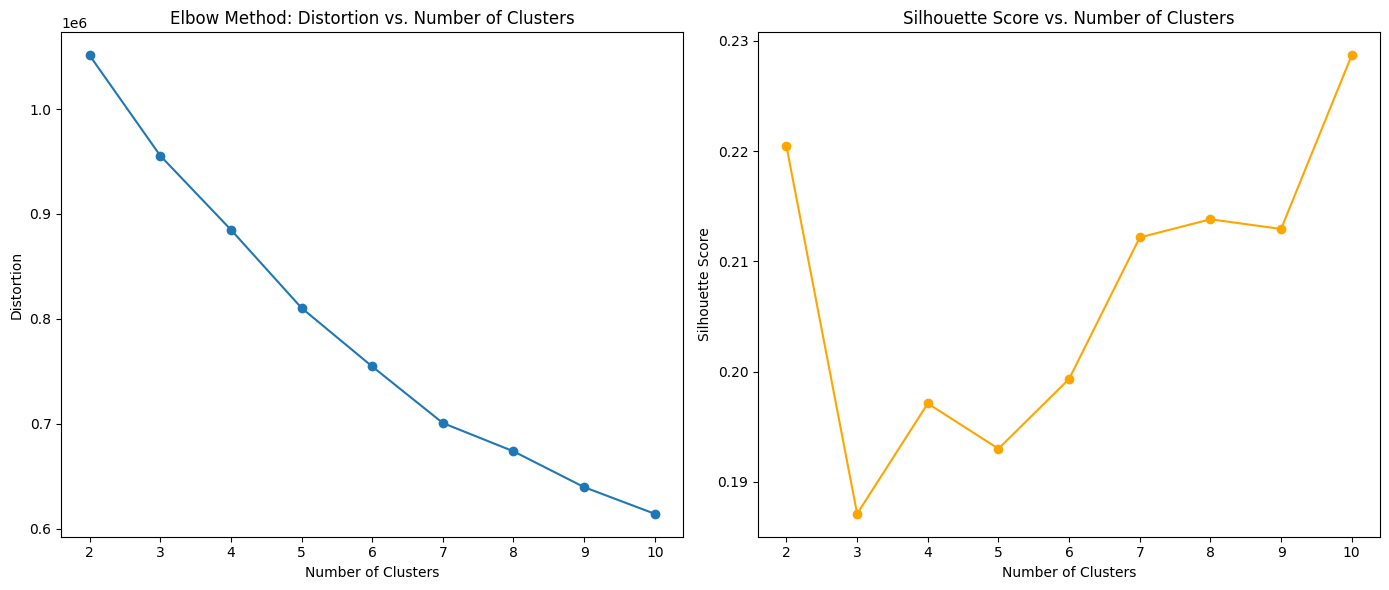

Optimal k:  10


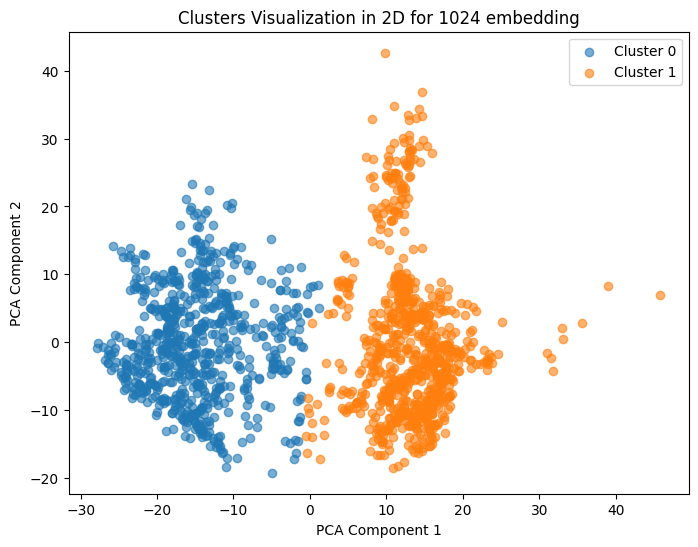

[[432 393]
 [281 416]]
{0: 0, 1: 1}
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       825
           1       0.51      0.60      0.55       697

    accuracy                           0.56      1522
   macro avg       0.56      0.56      0.56      1522
weighted avg       0.56      0.56      0.56      1522



In [8]:
embeddings, labels = preprocess_df(df_1024)
optimal_k = find_optimal_k(embeddings)
print('Optimal k: ', optimal_k)
optimal_k = 2
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 1024)

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Using embedding with 2048 length

In [10]:
df_2048 = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_2048_CDI.csv', header=None)
# df_2048.head()
print(df_2048.shape)

(1522, 2049)


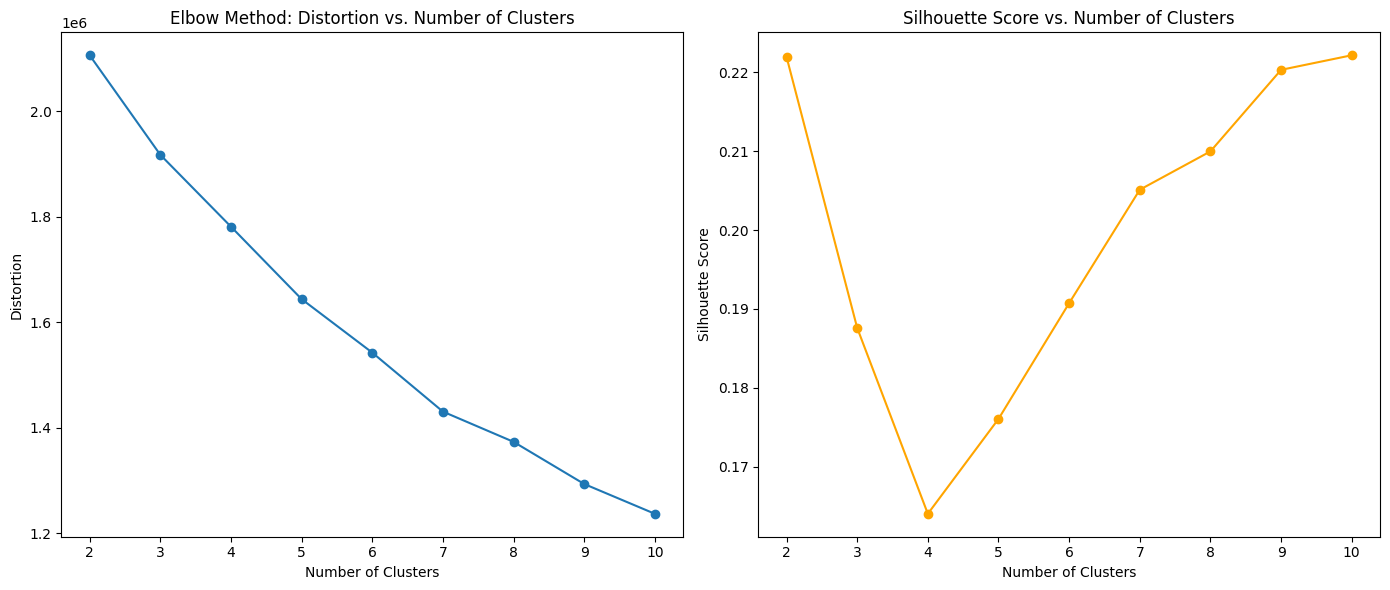

Optimal k:  10


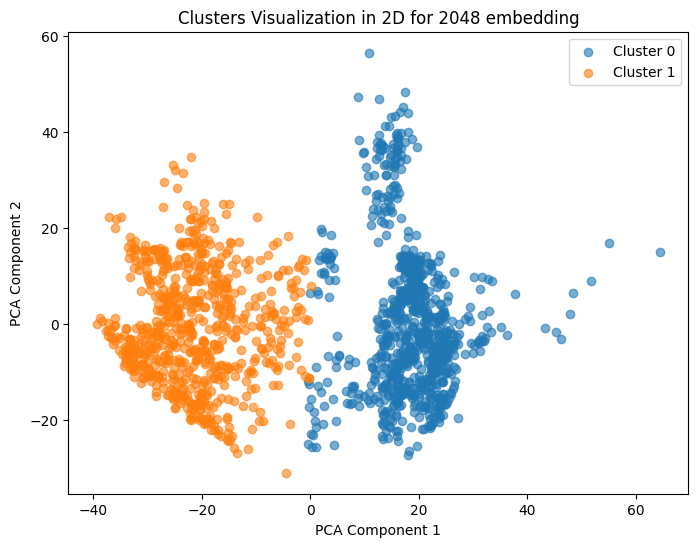

[[402 423]
 [417 280]]
{1: 0, 0: 1}
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       825
           1       0.51      0.60      0.55       697

    accuracy                           0.55      1522
   macro avg       0.56      0.56      0.55      1522
weighted avg       0.56      0.55      0.55      1522



In [11]:
embeddings, labels = preprocess_df(df_2048)
optimal_k = find_optimal_k(embeddings)
print('Optimal k: ', optimal_k)
optimal_k =2
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 2048)
aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Using embedding with 256 length

In [12]:
df_256 = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_256_CDI.csv', header=None)
print(df_256.shape)

(1522, 257)


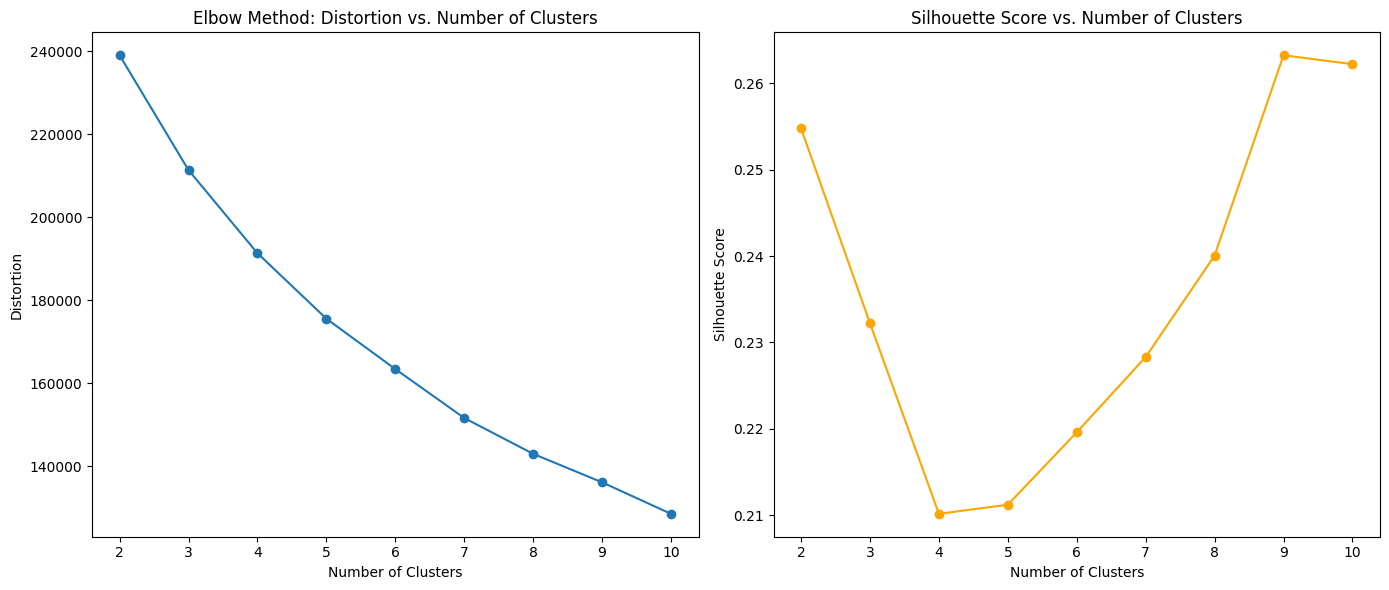

Optimal k:  9


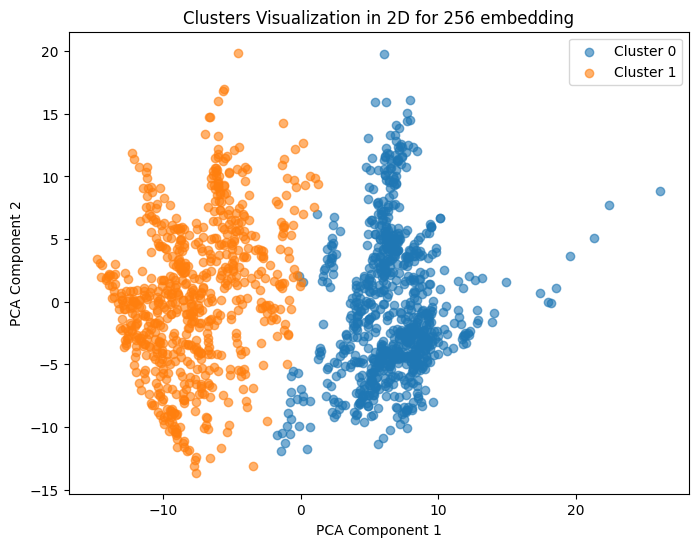

[[402 423]
 [418 279]]
{1: 0, 0: 1}
              precision    recall  f1-score   support

           0       0.60      0.51      0.55       825
           1       0.51      0.60      0.55       697

    accuracy                           0.55      1522
   macro avg       0.56      0.56      0.55      1522
weighted avg       0.56      0.55      0.55      1522



In [13]:
embeddings, labels = preprocess_df(df_256)
optimal_k = find_optimal_k(embeddings)
print('Optimal k: ', optimal_k)
optimal_k=2
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 256)

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Using embedding with 4096 length

In [14]:
df_4096 = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_4096_CDI.csv', header=None)
print(df_4096.shape)

(1522, 4097)


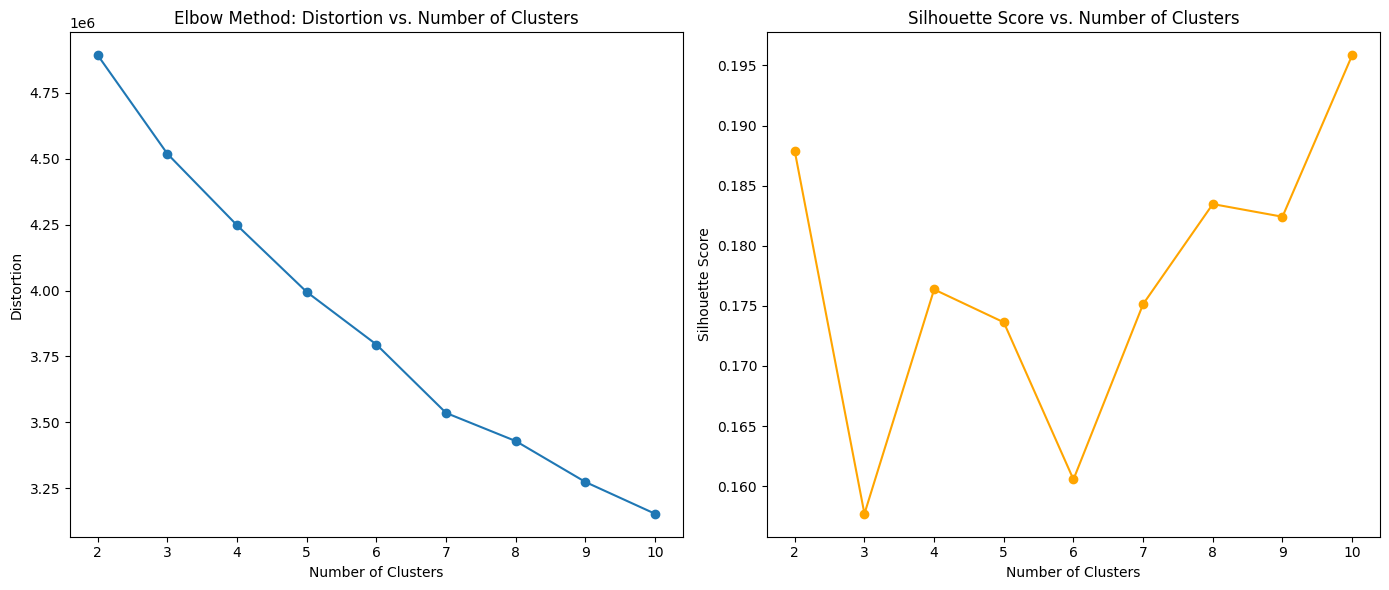

Optimal k:  10


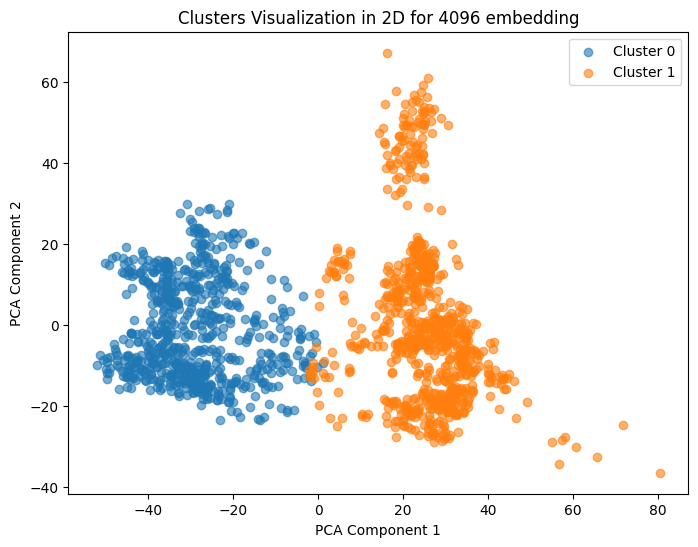

[[425 400]
 [279 418]]
{0: 0, 1: 1}
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       825
           1       0.51      0.60      0.55       697

    accuracy                           0.55      1522
   macro avg       0.56      0.56      0.55      1522
weighted avg       0.56      0.55      0.55      1522



In [15]:
embeddings, labels = preprocess_df(df_4096)
optimal_k = find_optimal_k(embeddings)
print('Optimal k: ', optimal_k)
optimal_k=2
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 4096)

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Using embedding with 8192 length

In [16]:
df_8192 = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_8192_CDI.csv', header=None)

Optimal k:  2


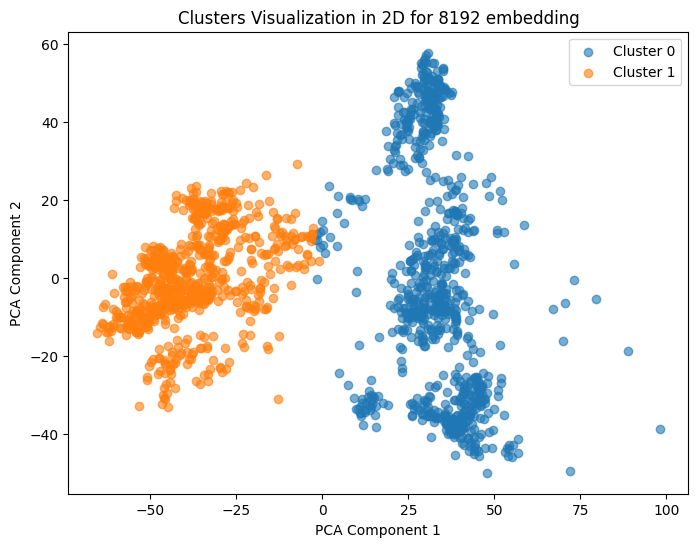

[[395 430]
 [417 280]]
{1: 0, 0: 1}
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       825
           1       0.51      0.60      0.55       697

    accuracy                           0.56      1522
   macro avg       0.56      0.56      0.56      1522
weighted avg       0.56      0.56      0.56      1522



In [17]:
embeddings, labels = preprocess_df(df_8192)
# optimal_k = find_optimal_k(embeddings)
# optimal_k comes out to be 10, so hungrarian wont work because target has only 2 labels?
optimal_k =2
print('Optimal k: ', optimal_k)
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 8192)

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

## Using K-Means for individual embeddings 

### Chemberta

In [18]:
df_chemberta = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_Chemberta.csv')
print(df_chemberta.shape)
# df_chemberta.head()

(1522, 385)


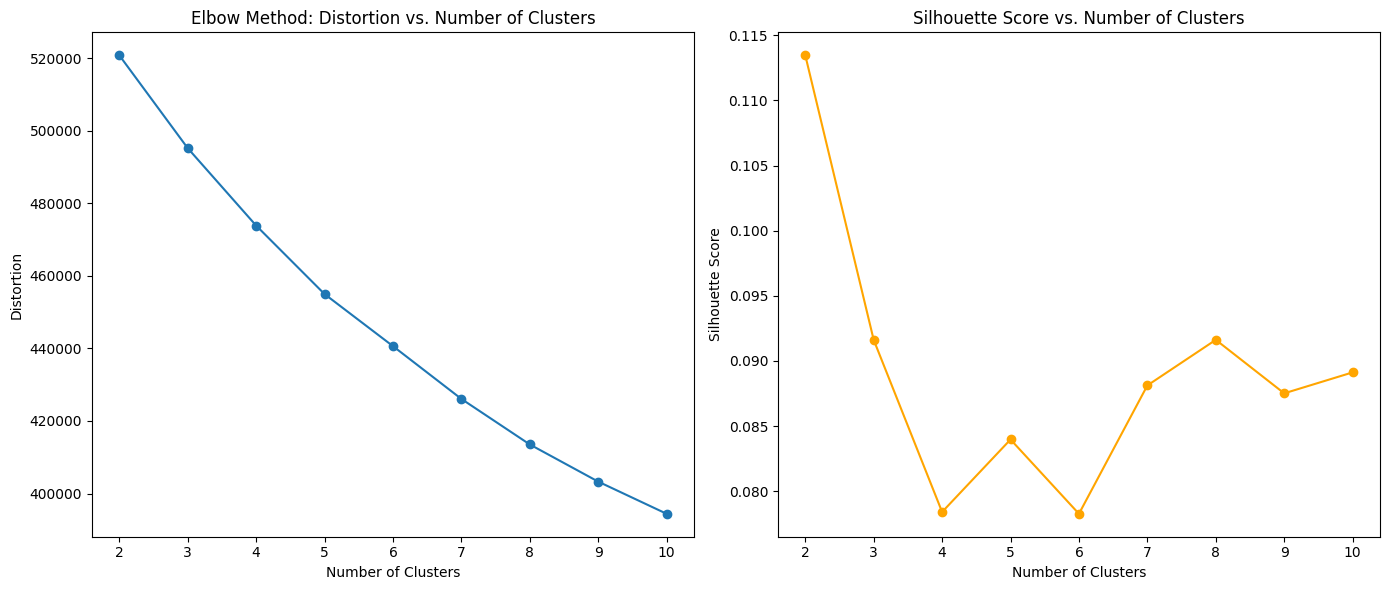

Optimal k:  2


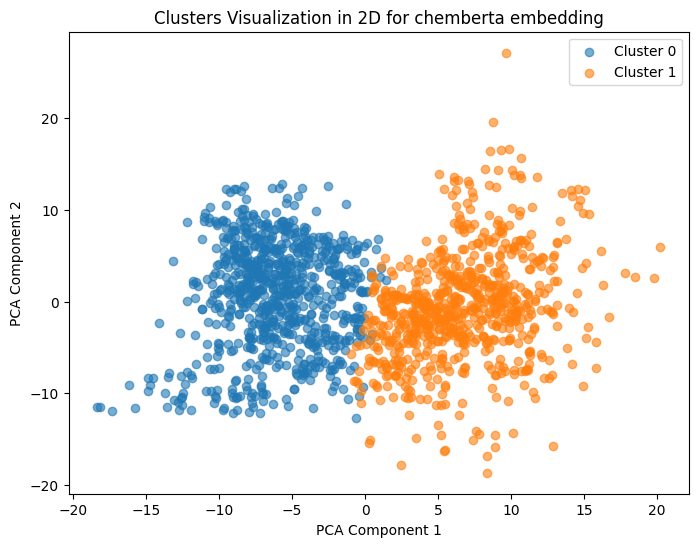

[[370 455]
 [424 273]]
{1: 0, 0: 1}
              precision    recall  f1-score   support

           0       0.62      0.55      0.59       825
           1       0.53      0.61      0.57       697

    accuracy                           0.58      1522
   macro avg       0.58      0.58      0.58      1522
weighted avg       0.58      0.58      0.58      1522



In [19]:
embeddings, labels = preprocess_df(df_chemberta)
optimal_k = find_optimal_k(embeddings)
print('Optimal k: ', optimal_k)
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 'chemberta')

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Imagemol

In [21]:
df_Imagemol = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_Imagemol.csv', sep='\t')
print(df_Imagemol.shape)
df_Imagemol.head()

(1522, 10001)


,ID,ImageMol_0,ImageMol_1,ImageMol_2,ImageMol_3,ImageMol_4,ImageMol_5,ImageMol_6,ImageMol_7,ImageMol_8,...,ImageMol_9990,ImageMol_9991,ImageMol_9992,ImageMol_9993,ImageMol_9994,ImageMol_9995,ImageMol_9996,ImageMol_9997,ImageMol_9998,ImageMol_9999
0,C0,-0.610007,0.016800,0.812276,0.308579,-0.836737,-0.711772,-0.076047,-0.954176,-0.802439,...,-1.551483,0.648887,0.194820,-0.884571,-0.136363,-0.206171,-0.320296,0.916117,0.009059,0.723911
1,C1,-1.187126,0.390284,0.033433,-0.035141,-1.726654,0.182529,0.510998,-0.021536,-1.099981,...,-2.518608,-0.498553,0.417460,-0.122327,-0.114669,-0.660041,-0.481993,0.380464,-1.032106,-0.745217
2,C10,-1.513527,0.342749,-0.374333,0.618950,-1.885831,-0.646042,0.376470,-0.313764,-0.763120,...,-1.463550,0.396783,0.471996,-0.857053,0.449736,-0.573912,-0.207698,0.714132,0.103965,0.061482
3,C100,-2.664551,1.193593,2.642063,0.385726,-1.584451,-0.613730,-0.617510,0.982062,-0.905849,...,-2.349475,-1.067600,0.544324,-0.789031,1.771227,-2.277831,-1.656670,1.599118,0.719259,-0.154899
4,C1000,-0.772643,0.898780,0.314050,-0.710656,-1.706188,-0.071215,0.992310,-0.132612,-0.922048,...,-2.119186,-0.355930,0.345839,-0.888670,0.282865,-1.548640,-0.792778,0.196403,-0.448423,-0.962643


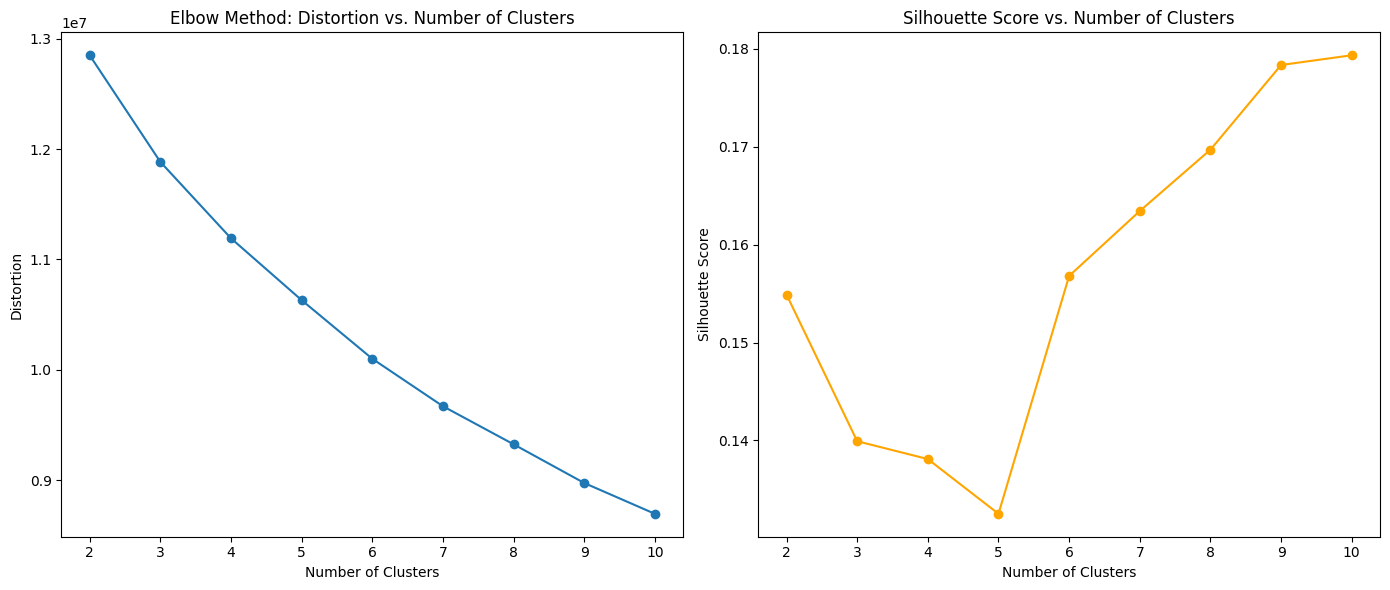

Optimal k:  10


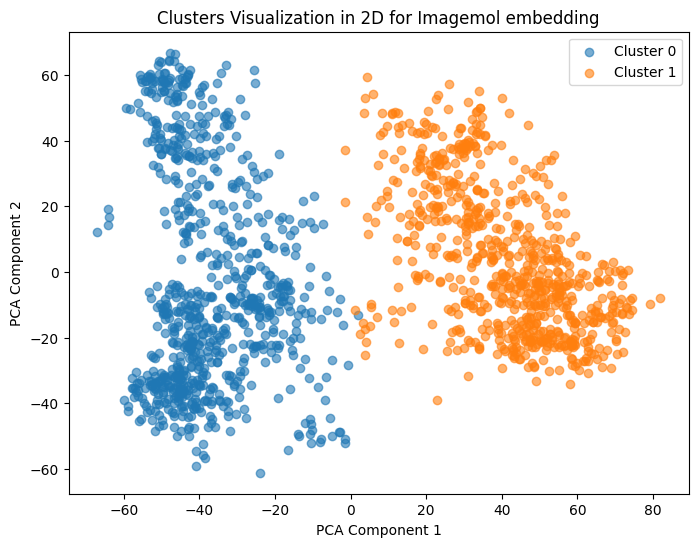

[[382 443]
 [410 287]]
{1: 0, 0: 1}
              precision    recall  f1-score   support

           0       0.61      0.54      0.57       825
           1       0.52      0.59      0.55       697

    accuracy                           0.56      1522
   macro avg       0.56      0.56      0.56      1522
weighted avg       0.57      0.56      0.56      1522



In [22]:
embeddings, labels = preprocess_df(df_Imagemol)
optimal_k = find_optimal_k(embeddings)
# optimal k was 9, resetting it to 2 for hungrarian to work
print('Optimal k: ', optimal_k)
optimal_k = 2
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 'Imagemol')

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Mordred

In [23]:
df_mordred = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_mordred.csv')
print(df_mordred.shape)
# df_mordred.head()

(1522, 1423)


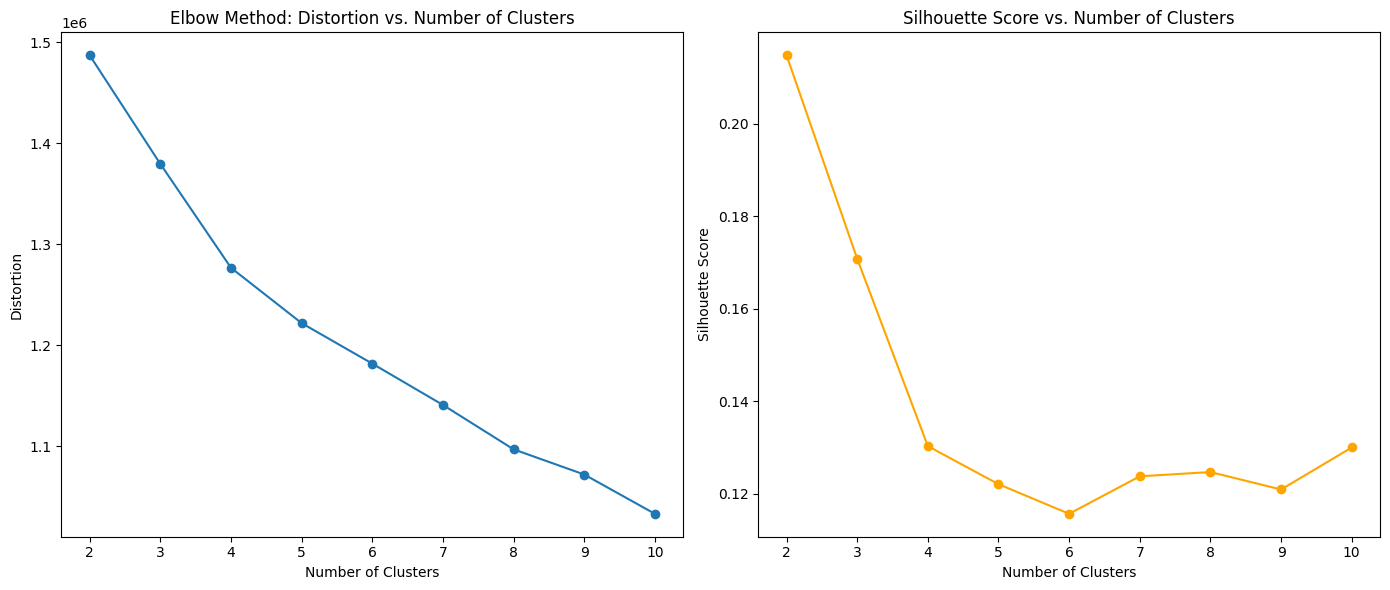

Optimal k:  2


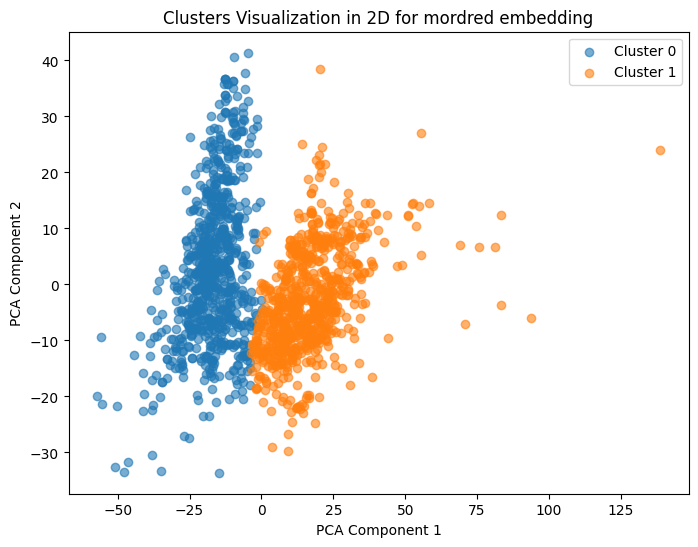

[[472 353]
 [279 418]]
{0: 0, 1: 1}
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       825
           1       0.54      0.60      0.57       697

    accuracy                           0.58      1522
   macro avg       0.59      0.59      0.58      1522
weighted avg       0.59      0.58      0.59      1522



In [24]:
embeddings, labels = preprocess_df(df_mordred)
optimal_k = find_optimal_k(embeddings)
# optimal k was 3, resetting it to 2 for hungrarian to work
print('Optimal k: ', optimal_k)
optimal_k = 2
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 'mordred')

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Grover

In [25]:
df_grover = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_grover.csv')
print(df_grover.shape)
# df_grover.head()

(1522, 5001)


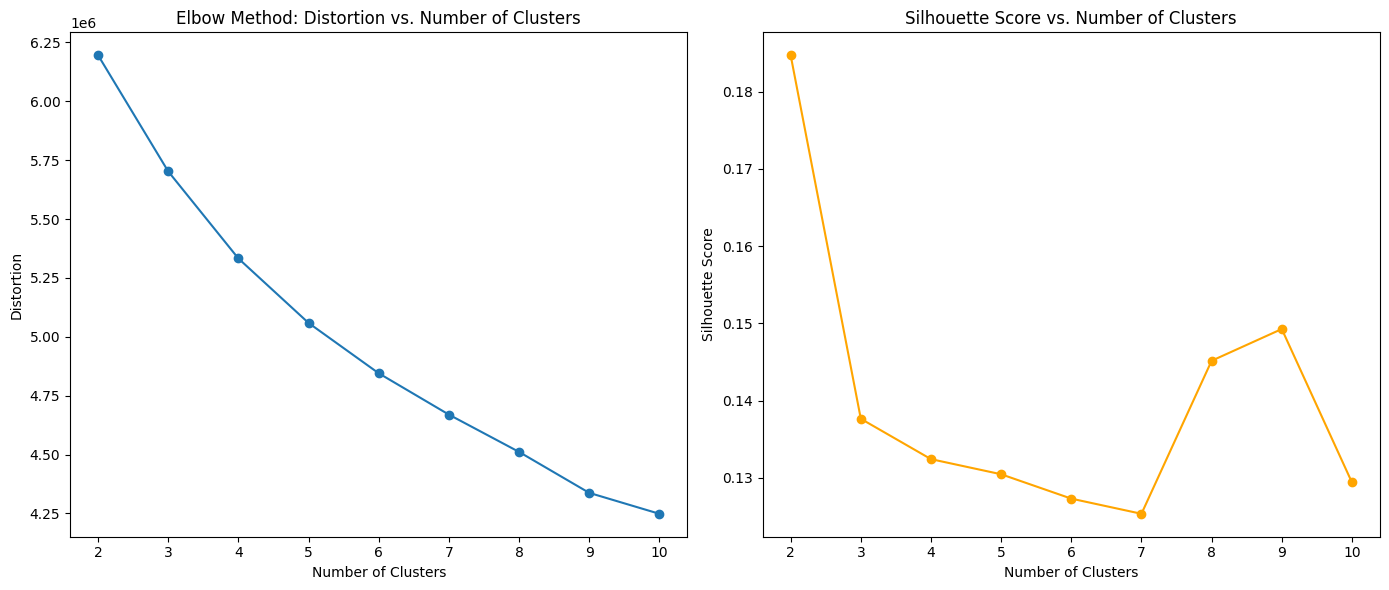

Optimal k:  2


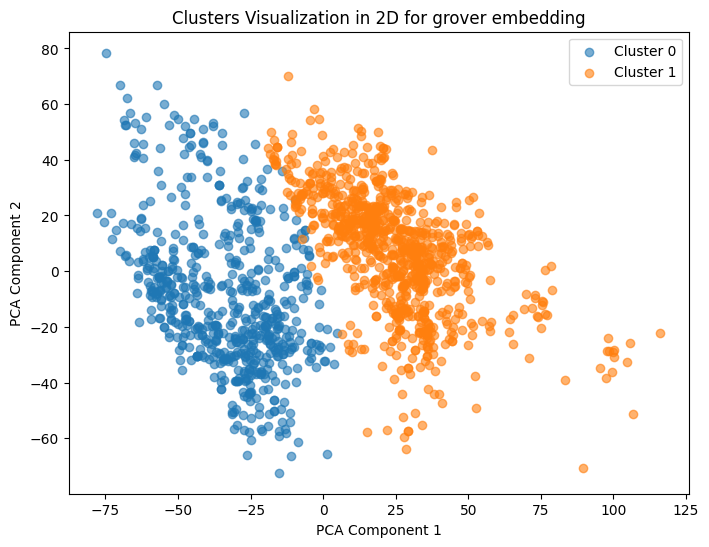

[[374 451]
 [267 430]]
{0: 0, 1: 1}
              precision    recall  f1-score   support

           0       0.58      0.45      0.51       825
           1       0.49      0.62      0.54       697

    accuracy                           0.53      1522
   macro avg       0.54      0.54      0.53      1522
weighted avg       0.54      0.53      0.53      1522



In [26]:
embeddings, labels = preprocess_df(df_grover)
optimal_k = find_optimal_k(embeddings)

print('Optimal k: ', optimal_k)
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 'grover')

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Mopac

In [27]:
df_mopac = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_mopac.csv')
print(df_mopac.shape)
# df_mopac.head()

(1522, 213)


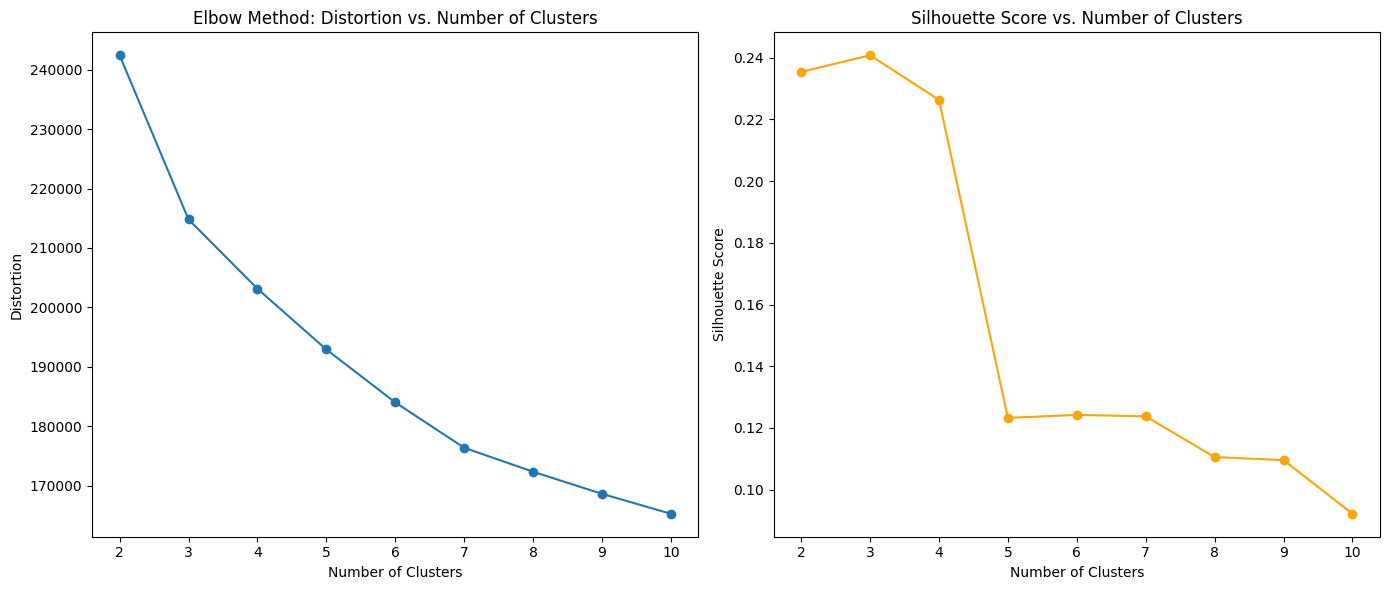

Optimal k:  3


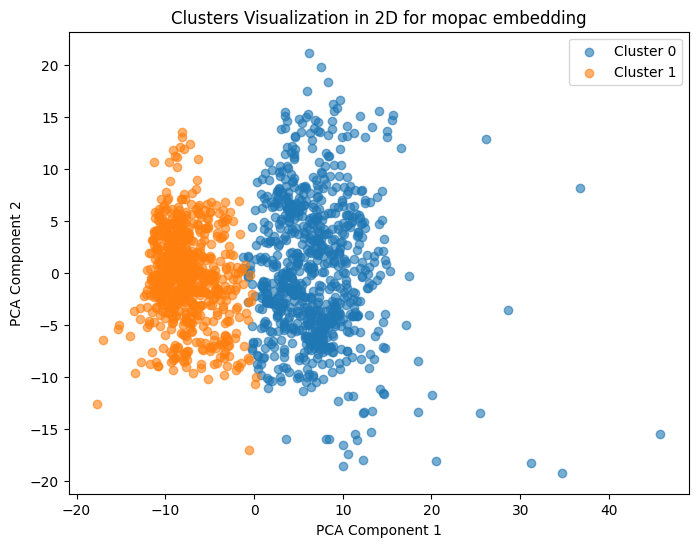

[[383 442]
 [425 272]]
{1: 0, 0: 1}
              precision    recall  f1-score   support

           0       0.62      0.54      0.57       825
           1       0.53      0.61      0.56       697

    accuracy                           0.57      1522
   macro avg       0.57      0.57      0.57      1522
weighted avg       0.58      0.57      0.57      1522



In [28]:
embeddings, labels = preprocess_df(df_mopac)
optimal_k = find_optimal_k(embeddings)
# optimal k was 3, resetting it to 2 for hungrarian to work
print('Optimal k: ', optimal_k)
optimal_k = 2
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 'mopac')

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))

### Signaturizer

In [29]:
df_signaturizer = pd.read_csv(f'../../chemdice/final_results/Data_benchmarking/{type_dir}_Chemicaldice_data/{type_dir}_signaturizer.csv')
print(df_signaturizer.shape)
# df_signaturizer.head()

(1522, 3201)


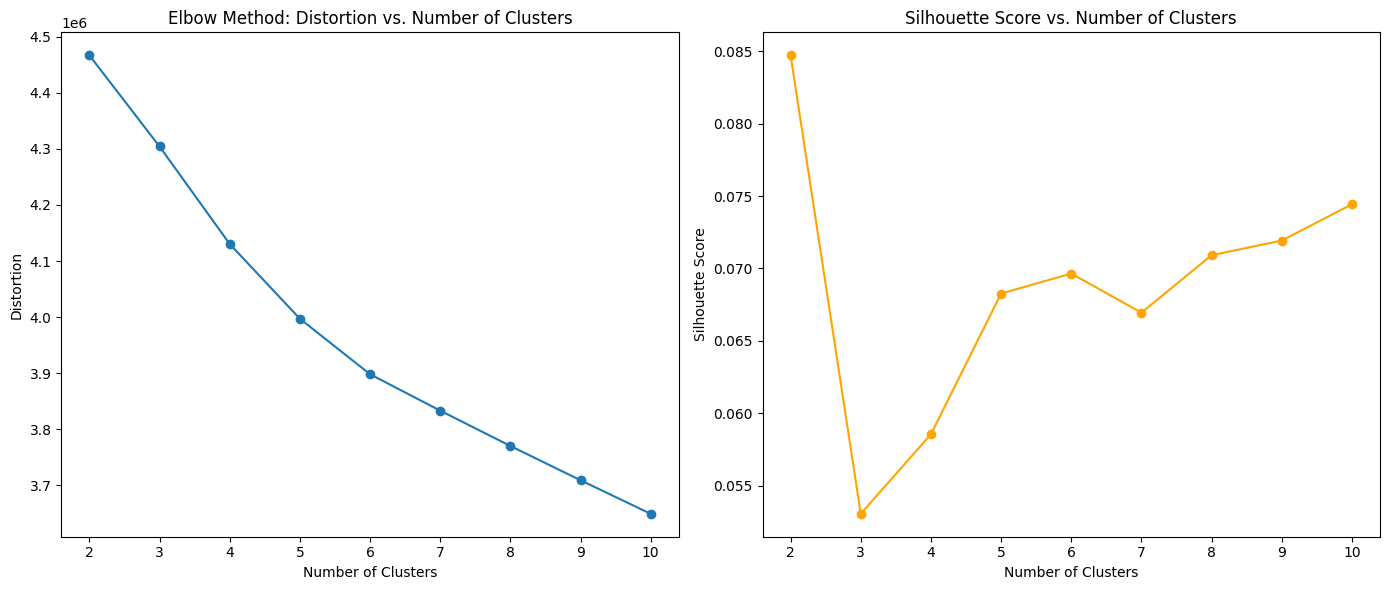

Optimal k:  2


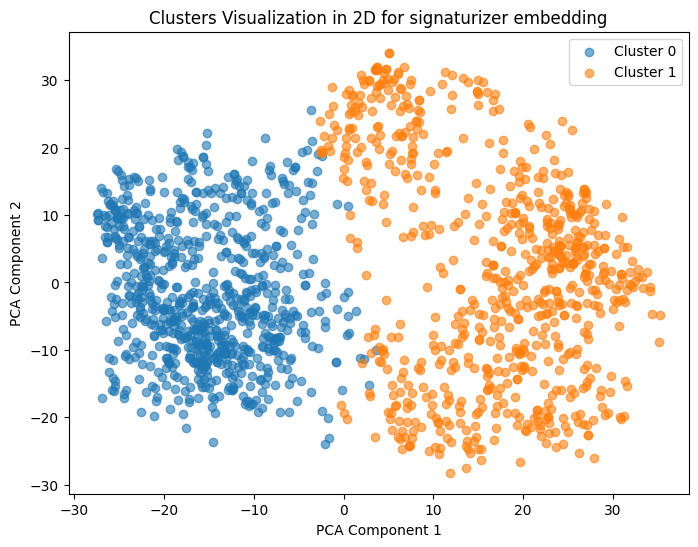

[[376 449]
 [416 281]]
{1: 0, 0: 1}
              precision    recall  f1-score   support

           0       0.62      0.54      0.58       825
           1       0.53      0.60      0.56       697

    accuracy                           0.57      1522
   macro avg       0.57      0.57      0.57      1522
weighted avg       0.57      0.57      0.57      1522



In [30]:
embeddings, labels = preprocess_df(df_signaturizer)
optimal_k = find_optimal_k(embeddings)
print('Optimal k: ', optimal_k)
cluster_labels = clustering_using_kmeans(optimal_k, embeddings, 'signaturizer')

aligned_cluster_labels = find_aligned_cluster_labels(true_labels, cluster_labels)

# accuracy = accuracy_score(true_labels, aligned_cluster_labels)
# print(accuracy)
print(classification_report(true_labels, aligned_cluster_labels))